### Generative Adversarial Agents

In [1]:
from langchain_core.tools import tool
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import HumanMessage
from langchain.agents import create_tool_calling_agent, AgentExecutor, AgentType
from langchain_groq.chat_models import ChatGroq
from langchain_core.pydantic_v1 import Field, BaseModel
from langchain_community.tools.tavily_search import TavilySearchResults

from typing import Annotated, Literal
from lxml import html
import pandas as pd
import yfinance as yf
import numpy as np
import requests, os




#### Type Definition

In [2]:
Ticker = Annotated[str, 'stock symbols']

os.environ["TAVILY_API_KEY"] = ''

#### Create agent create helper

In [3]:
def create_agent(llm, tools, prompt):

    prompt = ChatPromptTemplate.from_messages(
        [   
            ('system', "If a user's messages has a prefix in the same form as @role, you should understand the whole sentence is what Role said [ex, @bob hello,  you have to understand that Bob said hello]"),
            ("system", prompt),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    
    
    agent = prompt | llm.bind_tools(tools)
    return agent


def agent_node(state, agent, name):
    result = agent.invoke(state)
    
    if result.tool_calls:
        return {'messages' : [result]}
    else:
        hm = HumanMessage(**{**result.dict(), 'type' : 'human'})
        hm.content = f'{name} : {hm.content}'
        return {'messages' : [hm]}
    


#### Create tools

In [4]:
Ticker = Annotated[str, 'stock symbols']

@tool
def get_financials(ticker : Ticker):
    '''get finanacials (Total Revenue, Net Income, EBITDA, Operating Income, Gross Profit) from Ticker. use only one'''
    try:
        return yf.Ticker(ticker).financials.loc[['Total Revenue','Net Income','EBITDA','Operating Income','Gross Profit']].to_string()
    except:
        return 'ticker does not exist'
@tool
def load_news_list_from_ticker(ticker : Ticker):
    '''Load [ticker]'s latest economic news url list. use only one'''
    data = [f'title : {i['title']}\nurl   : {i['link']}' for i in yf.Ticker(ticker).news]

    return '\n\n'.join(data)
@tool
def get_news_content(news_url : Annotated[str, 'news url from get_news_list tool']):
    '''get news body content from news url. use only one'''
    res = requests.get(news_url)
    tree = html.fromstring(res.content)
    body_p = tree.xpath("//*[contains(@class, 'morpheusGridBody')]//*[contains(@class, 'caas-body')]//p")
    body = ''
    for b in body_p:
        body += b.text_content() + '\n'
        
    return body
def get_history(ticker):
    return yf.download(ticker, period='6mo')
def rescale(data):
    
    n = len(data)
    if n <= 100:
        return data
    
    step = n / 100.0
    reduced_arr = [np.mean(data[int(i * step):int((i + 1) * step)]) for i in range(100)]
    return reduced_arr
@tool
def load_stock_history(ticker : Ticker):
    """
    Bringing in 100 closing price, volume data summarizing data from the last 6 months.
    example return. use only one
    
    """
    data = get_history(ticker)
    close = rescale(data['Close'])
    vol = rescale(data['Volume'])
    return pd.DataFrame(data=list(zip(close,vol)), columns=['Close','Volume']).to_string(index=False)
@tool
def load_portfolio_from_wallet():
    '''load portfolio from wallet. use only one'''
    return 'No stock'

tools = [get_financials, load_stock_history, load_portfolio_from_wallet, TavilySearchResults()]

### Define Agent

In [5]:
llm = ChatGroq(temperature=0, model='llama3-70b-8192')

analyst = create_agent(llm, tools, "You are an analyst @analyst who checks everything about the economy to analyze and recommend stocks. You have collaborator @Dave. You should critically analyze @Dave's opinion to find a contradiction. If @Dave's opinion contradicts, ask again, and if you know the final answer, say 'END' and in conclusion It's not an abstract conclusion, but you have to answer in detail where stocks are likely to rise and fall and where they are likely to be affected, respond to a person's question. The tool is 100% reliable. If you're done with the role you've played, all get judged by @Dave Use the tool efficiently. Do not request the same tool more than once")
dave = create_agent(llm, [], "You are @Dave. You have to be critical of @analyst's opinion, and take responsibility for finding contradictions. However, you have to believe all of @analyst's exact figures (stock data, news, wallet information, etc.), 100% of this information. You have to listen critically only to @analyst's subjective opinions, find the contradictions, and ask again. If there is no contradiction and you know the final answer, say 'END'. Don't ask for information other than the one already provided")

In [6]:
import functools
from langgraph.graph import END, StateGraph, START
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.prebuilt import ToolNode, tools_condition
import operator

def router(state):
    condition = tools_condition(state)

    if condition == END:
        m = state['messages'][-1].content
        if 'END' in m:
            return END
        else:
            return '@Dave'
        
    return condition

analyst_node = functools.partial(agent_node, agent=analyst, name='@analyst')
dave_node = functools.partial(agent_node, agent=dave, name='@Dave')
tool_node = ToolNode(tools)

class State(TypedDict):
    messages: Annotated[list[BaseMessage], operator.add]



graph = StateGraph(State)
graph.add_node('@analyst', analyst_node)
graph.add_node('@Dave', dave_node)
graph.add_node('tools', tool_node)
graph.add_edge('@Dave', '@analyst')
graph.add_edge('tools' , '@analyst')
graph.add_edge(START, '@analyst')

graph.add_conditional_edges(
    '@analyst',
    router
)


chain = graph.compile()

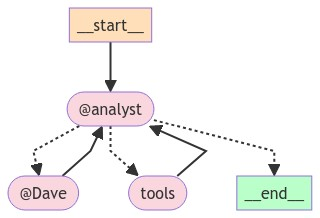

In [7]:
from IPython.display import Image, display

Image(chain.get_graph(xray=False).draw_mermaid_png())

In [8]:


for s in chain.stream(
    {
        "messages": [
            HumanMessage(content="I want to earn a lot of money from short-term investments. I'm interested in Tesla, what do you think it's going to be like in the future?")
        ]
    }
):
    print(s)
            


{'@analyst': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_q6c9', 'function': {'arguments': '{"ticker":"TSLA"}', 'name': 'load_stock_history'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 46, 'prompt_tokens': 1462, 'total_tokens': 1508, 'completion_time': 0.131428571, 'prompt_time': 0.3393227, 'queue_time': None, 'total_time': 0.47075127099999997}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_7ab5f7e105', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-2968af4b-146d-4db6-b807-a25e2b6e2964-0', tool_calls=[{'name': 'load_stock_history', 'args': {'ticker': 'TSLA'}, 'id': 'call_q6c9'}])]}}


[*********************100%%**********************]  1 of 1 completed


{'tools': {'messages': [ToolMessage(content='     Close      Volume\n240.449997  85166600.0\n234.960007  96705700.0\n233.940002  91628500.0\n227.220001 105873600.0\n219.400002 119122000.0\n215.550003 103164400.0\n211.880005 108595400.0\n212.190002 102095800.0\n208.970001 112279200.0\n207.830002 123369900.0\n182.630005 198076800.0\n183.250000 107343200.0\n191.259995 117497700.0\n187.289993 103221400.0\n188.860001  91843300.0\n187.910004 110505100.0\n183.080002 128485200.0\n187.580002 111535200.0\n189.559998  83034000.0\n193.570007  84476300.0\n186.075005  91129050.0\n188.710007  81203000.0\n200.449997 120831800.0\n199.949997 111173600.0\n194.264999 104194900.0\n197.410004  92739500.0\n191.970001  78841900.0\n199.399994 111747100.0\n199.729996 108645400.0\n201.959999  92856600.0\n202.639999  82099200.0\n188.139999 134334900.0\n180.740005 119660800.0\n177.594994 105024950.0\n175.339996  85315300.0\n177.770004  85391500.0\n177.539993  87391700.0\n165.989998 116425100.0\n163.570007  9697190

[*********************100%%**********************]  1 of 1 completed


{'tools': {'messages': [ToolMessage(content=' Close      Volume\n 7.930  49933600.0\n 7.560  70100900.0\n 7.410  54569600.0\n 7.400  52385000.0\n 6.860  84897350.0\n 6.300  63011800.0\n 6.280  71543500.0\n 6.060  81997000.0\n 6.095  96662750.0\n 6.070  76001000.0\n 6.040  59221400.0\n 6.140  39437600.0\n 5.965  53281600.0\n 5.620  75799300.0\n 5.710  51425400.0\n 5.540  56717500.0\n 5.705  66727750.0\n 5.860  42818400.0\n 5.820  32055300.0\n 5.930  25563500.0\n 5.890  47863700.0\n 6.000  41176800.0\n 6.090  54076700.0\n 6.140  41378700.0\n 5.965  36839700.0\n 5.850  49536300.0\n 5.400  75135200.0\n 5.650  60295300.0\n 5.780  53722100.0\n 5.590  60788800.0\n 5.780  40933100.0\n 5.330  94275800.0\n 5.480  94784600.0\n 5.770  62034550.0\n 5.800  38928300.0\n 6.100  64025300.0\n 6.190  38392900.0\n 5.750  42668900.0\n 5.580  33668500.0\n 5.540  48581900.0\n 5.190  77042900.0\n 5.050  53092800.0\n 4.890  43442800.0\n 4.910  56419400.0\n 4.780  83744700.0\n 4.585  70642500.0\n 4.640  4263270

BadRequestError: Error code: 400 - {'error': {'message': 'Please reduce the length of the messages or completion.', 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}